# Classify Digits with the MNIST Dataset

## Overview

## Models

In [1]:
import torch
import torch.nn as nn
import tqdm as tqdm # fancy progress bars
import matplotlib.pyplot as plt
import torchvision # for loading MNIST dataset and visualizing images


In [2]:
torch.manual_seed(0) # for reproducibility if you care about that


In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)


In [3]:
def train(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=0.1,
):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Statistics dictionary
    stats = {"train_losses": [0], "test_losses": [0], "global_step": 0}

    # Training loop
    with tqdm.trange(
        num_epochs, desc="Training", unit="epoch"
    ) as epochs:  # Adjust the number of epochs
        for epoch in epochs:
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                stats["train_losses"].append(loss.item())
                stats["global_step"] += 1

                epochs.set_postfix_str(f"train loss: {stats['train_losses'][-1]:.6f}, test loss: {stats['test_losses'][-1]:.6f}")

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)

                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

            stats["test_losses"].append(test_loss / len(test_loader))

    return stats

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def plot_stats(stats):
    # Plot train and test losses
    plt.figure(figsize=(20, 4))
    plt.plot(stats["train_losses"], label="Train Loss")
    plt.plot(
        range(
            len(train_loader),
            len(stats["train_losses"]) + len(train_loader),
            len(train_loader),
        ),
        stats["test_losses"],
        label="Test Loss",
        c="r",
    )
    plt.title("Train and Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()


### Feed Forward Neural Network

#### Baseline Linear Classifier

In [4]:
if torch.backends.cudnn.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: mps


Training: 100%|██████████| 10/10 [00:37<00:00,  3.80s/epoch, train loss: 0.497007, test loss: 0.298439]


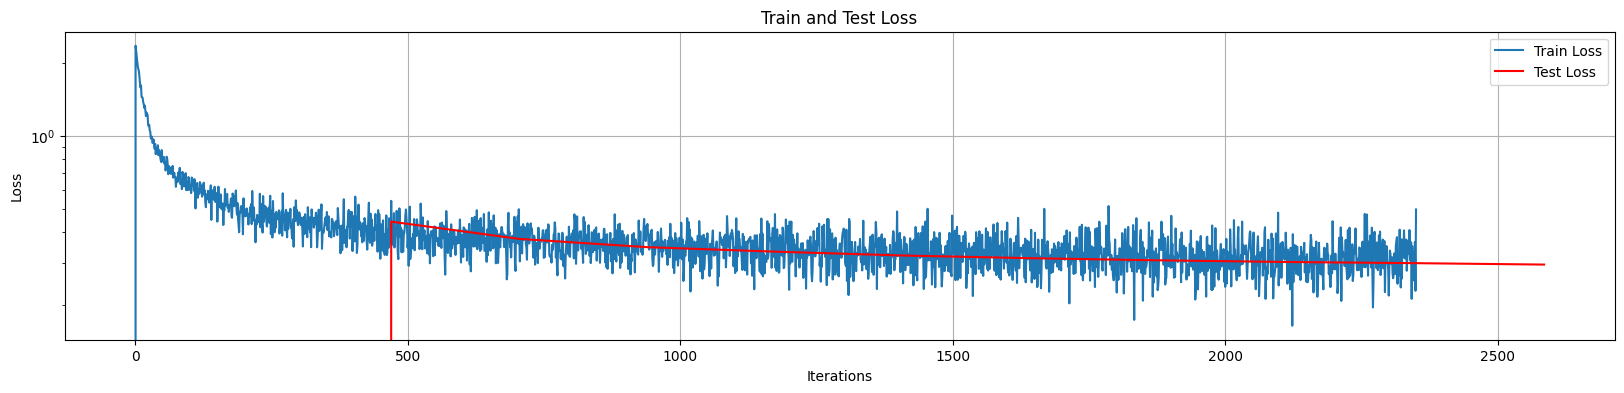

Accuracy: 0.9178
Model parameters: 7,850
Model size: 31,400 bytes


In [6]:
# Define the model
model = nn.Sequential(
    nn.Flatten(), nn.Linear(28 * 28, 10)  # MNIST images are 28x28 and have 10 classes
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


#### One-Hidden-Layer Fully Connected Multilayer NN

Training: 100%|██████████| 10/10 [00:38<00:00,  3.89s/epoch, train loss: 0.153938, test loss: 0.217459]


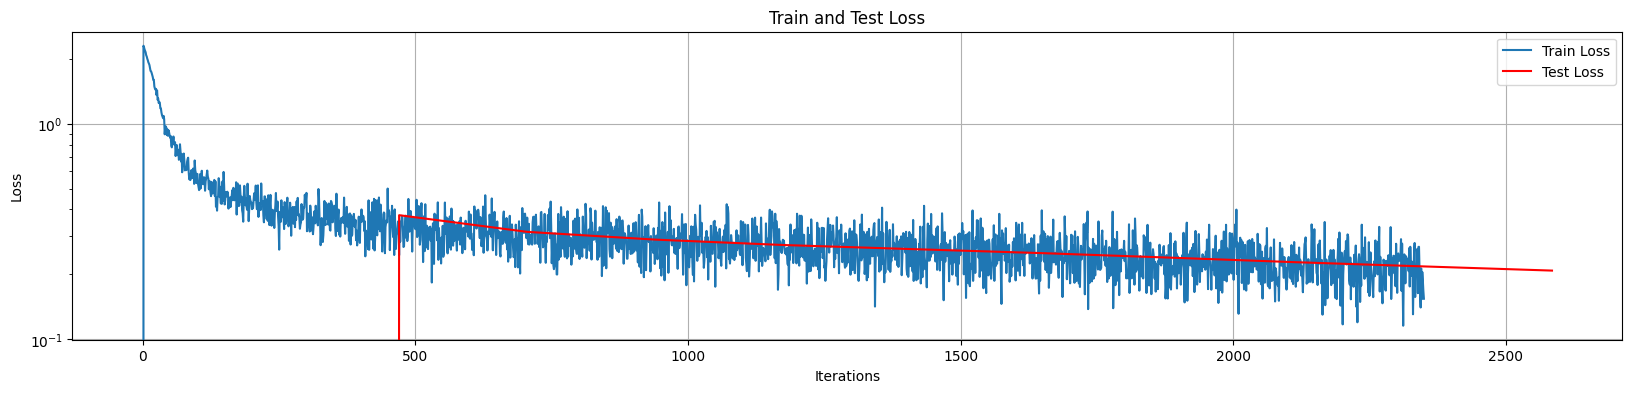

Accuracy: 0.9403
Model parameters: 203,530
Model size: 814,120 bytes


In [7]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.Tanh(),
    nn.Linear(256, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


#### Two-Hidden-Layer Fully Connected Multilayer NN

Training: 100%|██████████| 10/10 [00:41<00:00,  4.15s/epoch, train loss: 0.167867, test loss: 0.174486]


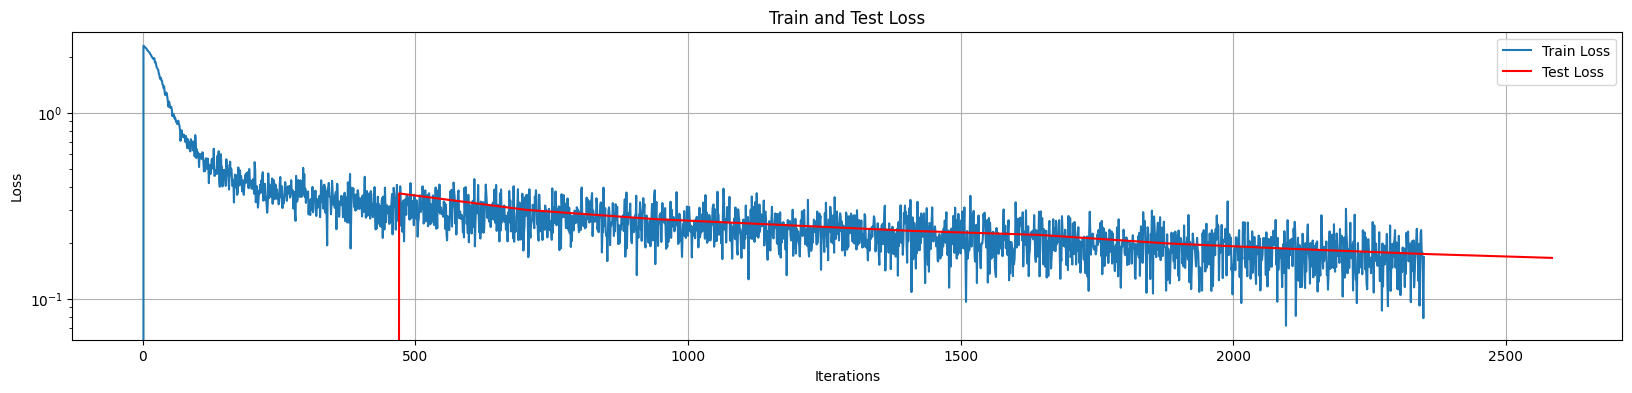

Accuracy: 0.9493
Model parameters: 235,146
Model size: 940,584 bytes


In [8]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


### Convolutional Neural Network

#### LeNet-1

Training: 100%|██████████| 10/10 [00:55<00:00,  5.55s/epoch, train loss: 0.178678, test loss: 0.136409]


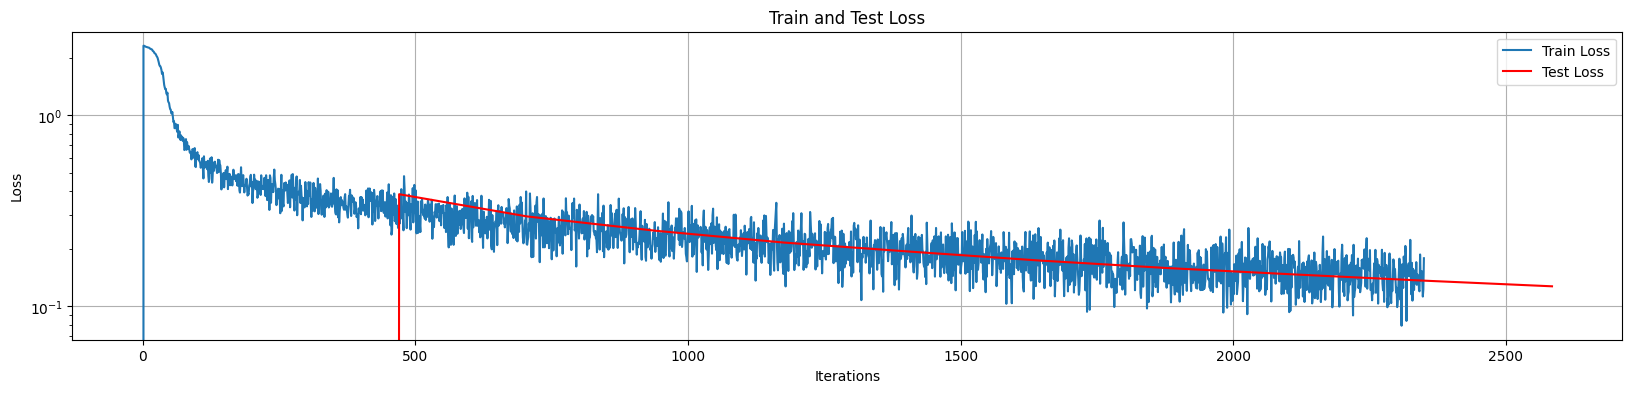

Accuracy: 0.9640
Model parameters: 3,246
Model size: 12,984 bytes


In [9]:
model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(4, 12, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(192, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


#### LeNet-4

Training: 100%|██████████| 10/10 [00:57<00:00,  5.78s/epoch, train loss: 0.132653, test loss: 0.088010]


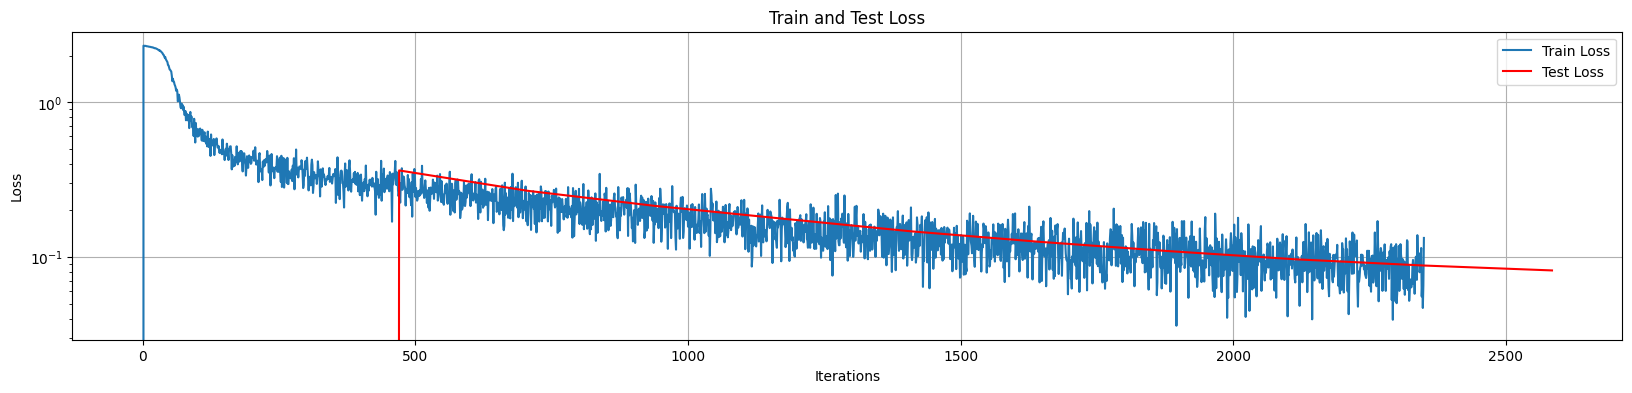

Accuracy: 0.9751
Model parameters: 35,906
Model size: 143,624 bytes


In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(4, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


#### LeNet-5

Training: 100%|██████████| 10/10 [00:59<00:00,  5.99s/epoch, train loss: 0.066296, test loss: 0.066624]


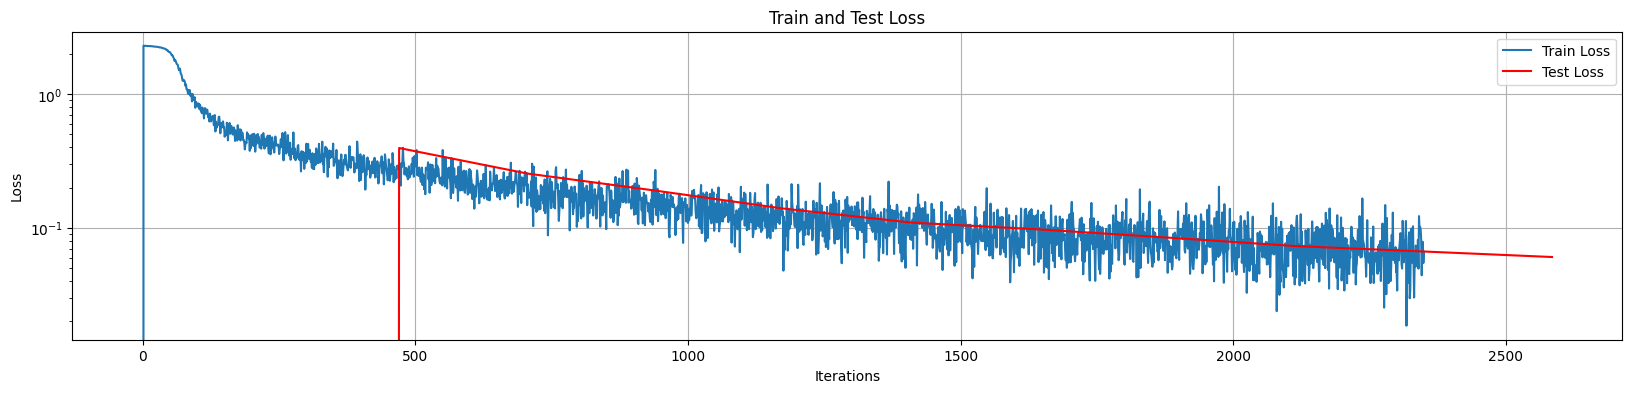

Accuracy: 0.9797
Model parameters: 47,154
Model size: 188,616 bytes


In [11]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


##### Optimized Training

In [12]:
def train(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=0.1,
    momentum=0.9, # Add 0.9 momentum
):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # Add momentum
    
    # Statistics dictionary
    stats = {"train_losses": [], "test_losses": [], "global_step": 0}

    # Training loop
    with tqdm.trange(
        num_epochs, desc="epochs", unit="epoch"
    ) as epochs:  # Adjust the number of epochs
        for epoch in epochs:
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                stats["train_losses"].append(loss.item())
                stats["global_step"] += 1

                epochs.set_postfix_str(f"loss: {loss.item():.4f}")

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)

                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

            stats["test_losses"].append(test_loss / len(test_loader))

    return stats


epochs: 100%|██████████| 10/10 [01:01<00:00,  6.20s/epoch, loss: 0.0239]


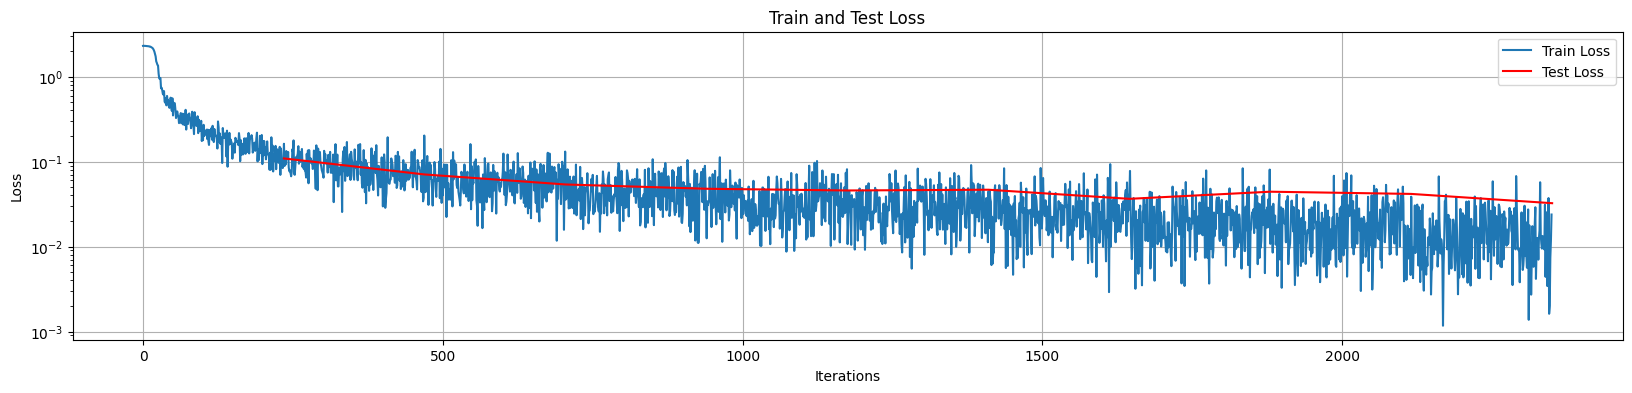

Accuracy: 0.9896
Model parameters: 47,154
Model size: 188,616 bytes


In [13]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


##### Smaller Batch Size

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False) # Doesnt matter if batch size is large


Training: 100%|██████████| 10/10 [02:40<00:00, 16.08s/epoch, train loss: 0.013270, test loss: 0.034080]


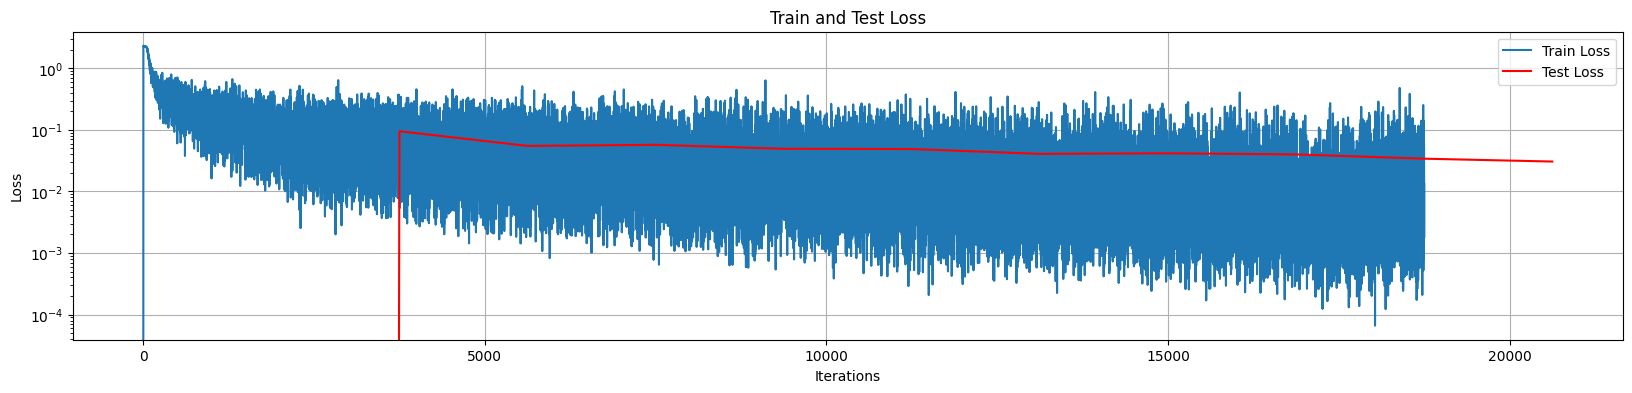

Accuracy: 0.9894
Model parameters: 47,154
Model size: 188,616 bytes


In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")


##### 2020's

Training: 100%|██████████| 10/10 [04:58<00:00, 29.85s/epoch, train loss: 0.004075, test loss: 0.036760]


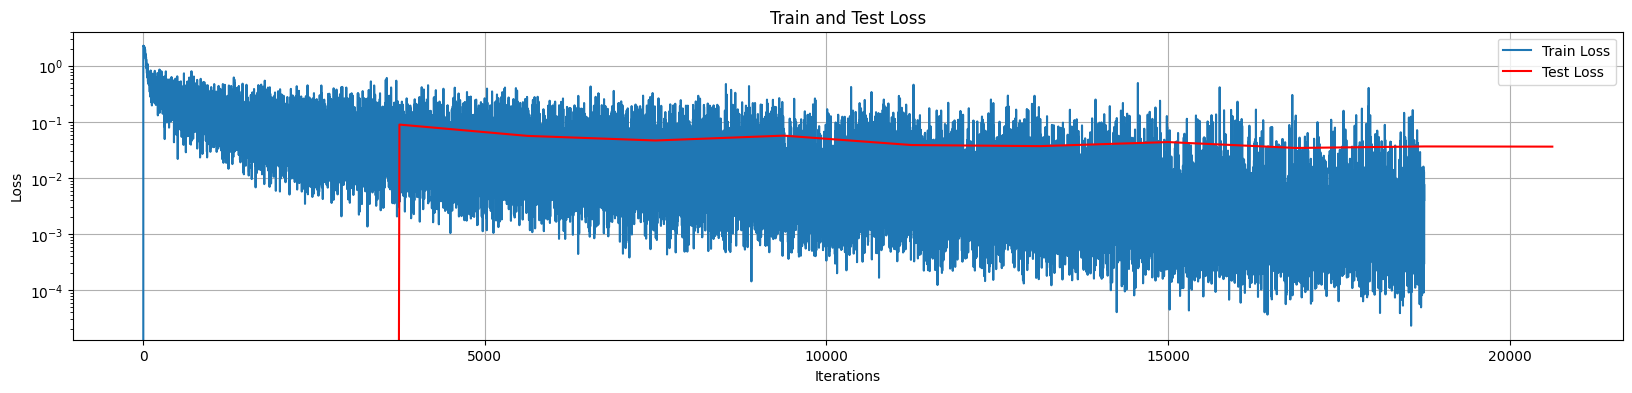

Accuracy: 0.9881
Model parameters: 765,322
Model size: 3,061,288 bytes


In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(64, 128, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")
